# Transfer Learning with LIME


We will talk  about transfer learning and LIME. With new data we want to evaluate our new model. Basically we use Resnet 50 again but scrap the last layer for our new layer. For the description please look at the notebook lime_explained_imagenet

## General preparations

In [5]:
import torch
import torchvision
import json
import matplotlib.pyplot as plt

import skimage.io 
import numpy as np
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import math

from os import listdir
from torch.utils.data import TensorDataset, dataloader
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score
import pickle

In [ ]:
!curl https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_128%28creative_commons%29.zip --output data.zip
!unzip data.zip -d .
!mv 'Architectural_Heritage_Elements_Dataset_128(creative_commons)' data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4107349532_2b25eafba4_m.jpg  
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4120135017_62d36afe8f_m.jpg  
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4120135233_64759d999d_m.jpg  
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4120142741_32cec161bc_m.jpg  
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4120916138_2d2b813707_m.jpg  
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4135588202_67797eb543_n.jpg  
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4140282705_fe8f4655ed_m.jpg  
  inflating: ./Architectural_Heritage_Elements_Dataset_128(creative_commons)/dome(outer)/4141346882_

In [121]:
model = torch.hub.load("pytorch/vision:v0.13.0", "resnet50", weights="IMAGENET1K_V2", skip_validation=True)


Using cache found in /home/snowparrot/.cache/torch/hub/pytorch_vision_v0.13.0


In [ ]:
model = model.cuda()

In [122]:
model_tt = torch.nn.Sequential(*list(model.children())[:-1])


In [ ]:
model_tt = model_tt.cuda()

In [ ]:
example_image = torchvision.io.read_image('labardor1.jpg')
example_image = example_image.float() / 255
example_image = torch.unsqueeze(example_image, dim=0)

## Construct Dataset

Here we will create the datasets.

In [11]:
classes_to_filename = {
    class_name: listdir(f'data/{class_name}')
for class_name in listdir('data')
}

In [13]:
classes_to_enumerate = {key: torch.unsqueeze(torch.unsqueeze(torch.tensor(i), dim=0), dim=0) for i, key in enumerate(classes_to_filename)}

In [14]:
def to_hot_encoding(i):
  vec_0 = torch.zeros([11])
  vec_0[i] = 1.0
  return torch.unsqueeze(vec_0, dim=0)

classes_to_hot = {
    key: to_hot_encoding(i)
    for i, key in enumerate(classes_to_filename)
}

In [16]:
list_train = list()
list_test = list()

train_test_split = 0.1


classes_to_n_train = {
    class_name: math.floor(
        len(
            classes_to_filename[class_name]
        ) * (1 - train_test_split)
    )
    for class_name in listdir('data')
}


class_to_i_train = defaultdict(
    lambda: 0
)

for class_pic, list_pic_file_name in classes_to_filename.items():
    for pic_file_name in list_pic_file_name:
        if not '.jpg' in pic_file_name:
            continue
        pic_tensor = torchvision.io.read_image(f'data/{class_pic}/{pic_file_name}')
        if pic_tensor.shape[0] == 1:
          continue
        if class_to_i_train[class_pic] <= classes_to_n_train[class_pic]:
            list_train.append(
                (torch.unsqueeze(pic_tensor, dim=0), 
                 classes_to_enumerate[class_pic]
            ))
            class_to_i_train[class_pic] += 1
        else:
            list_test.append(
                (torch.unsqueeze(pic_tensor, dim=0), classes_to_enumerate[class_pic])
            )
            
            

In [ ]:
def get_axis(liste, axis):
  return torch.cat([
      element[axis] for element in liste
  ], dim=0)


data = torch.utils.data.TensorDataset(
    get_axis(list_train, 0),
    get_axis(list_train, 1))

dataloader = torch.utils.data.DataLoader(
    data, batch_size=128
)



data_test = torch.utils.data.TensorDataset(
    get_axis(list_test, 0),
    get_axis(list_test, 1))

dataloader_test = torch.utils.data.DataLoader(
    data_test, batch_size=128
)

## Model Training


With using the $n - 1$ layer of Resnet50 we add a linear layer to the end. We don't change the Resnet50 network.

In [ ]:
t_lin = torch.nn.Linear(2048, 11)
t_lin = t_lin.cuda()

In [ ]:
EPOCHS = 10
loss = torch.nn.CrossEntropyLoss()
STEP_TRAIN = 128
t_lin = torch.nn.Linear(2048, 11)
t_lin = t_lin.cuda()
optimizer = torch.optim.Adam(t_lin.parameters()) 


for i_epochs in range(EPOCHS):
  for x, y in dataloader:
    optimizer.zero_grad()
    pred = model_tt(x.float().cuda()).detach()
    pred_classes = t_lin(pred[:, :, 0, 0])
    loss_pred = loss(pred_classes, y[:, 0].cuda())
    loss_pred.backward()
    optimizer.step()

  list_results = list()
  list_y = list()

  for x, y in dataloader_test:
      pred = model_tt(x.float().cuda()).detach()
      pred_classes = t_lin(pred[:, :, 0, 0])
      results = torch.max(torch.nn.Softmax(dim=0)(pred_classes), dim=1)[1]
      list_results.append(results)
      list_y.append(y)

  results_all = torch.cat(list_results).detach().cpu().numpy()
  y_all = torch.cat(list_y).detach().cpu().numpy()

  print(accuracy_score(y_all, results_all), f1_score(y_all, results_all,  average='micro'))

0.1491395793499044 0.1491395793499044
0.17495219885277247 0.17495219885277247
0.1988527724665392 0.1988527724665392
0.2198852772466539 0.2198852772466539
0.23422562141491396 0.23422562141491396
0.2304015296367113 0.2304015296367113
0.23422562141491396 0.23422562141491396
0.2323135755258126 0.2323135755258126
0.23422562141491396 0.23422562141491396
0.23422562141491396 0.23422562141491396


In [ ]:
torch.save(t_lin, open('transfer.model', 'wb+'))

In [125]:
# this use CPU
t_lin = torch.load(
    open('transfer.model', 'rb'),
    map_location=torch.device('cpu'))

Here we load the interpretation and test_data of the last attempt if we reuse the model.

In [129]:
classes_to_enumerate = pickle.load(open("classes_to_enumerate.data", "rb"))
list_test = pickle.load(open("list_test.list", "rb"))

## LIME with a test image

Here we use a test image to understand.

In [189]:
example_image, y_true = list_test[900]
y_true, classes_to_enumerate

(tensor([[9]]),
 {'column': tensor([[0]]),
  'flying_buttress': tensor([[1]]),
  'portal': tensor([[2]]),
  'dome(inner)': tensor([[3]]),
  'altar': tensor([[4]]),
  'bell_tower': tensor([[5]]),
  'vault': tensor([[6]]),
  'gargoyle': tensor([[7]]),
  'dome(outer)': tensor([[8]]),
  'apse': tensor([[9]]),
  'stained_glass': tensor([[10]])})

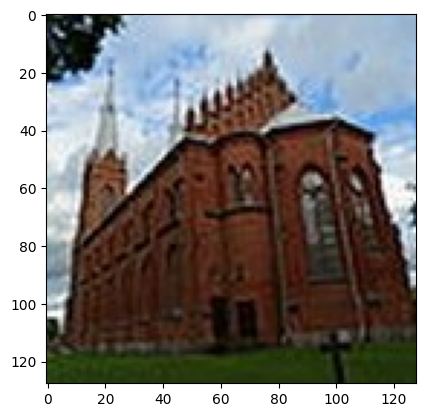

In [190]:
plt.imshow(example_image[0].permute(1, 2, 0)) 
plt.show()

In [191]:




def create_grid_segmentation(
    img,
    grid_n_x_axes = 10,
    grid_n_y_axes = 10
    ):
    size_y = img.shape[1]
    size_x = img.shape[0]

    step_y = math.floor(size_y / grid_n_y_axes)
    step_x = math.floor(size_x / grid_n_x_axes)

    class_area = 1
    result_pic = np.zeros((size_x, size_y), dtype=int)

    whiteboard = np.zeros(example_image.shape)
    for x_lower_border in range(0, size_x, step_x, ):
        for y_lower_border in range(0, size_y, step_y):
            x_higher_border = min(x_lower_border + step_x, size_x)
            y_higher_border = min(y_lower_border + step_y, size_y)

            if x_lower_border == x_higher_border or y_lower_border == y_higher_border:
                continue

            np_area = np.ones((x_higher_border - x_lower_border, y_higher_border - y_lower_border))  * class_area
            result_pic[x_lower_border:x_higher_border, y_lower_border:y_higher_border] = \
                np_area
            class_area += 1
    return result_pic



In [193]:
superpixels = create_grid_segmentation(example_image[0].permute(1, 2, 0), grid_n_x_axes=10, grid_n_y_axes=10)

In [194]:
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

121

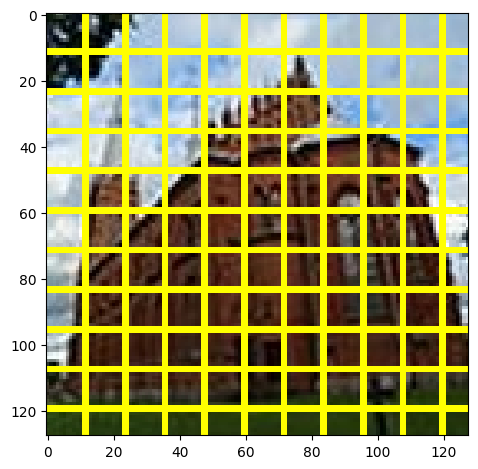

In [195]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(example_image[0].permute(1, 2, 0).detach().numpy(), superpixels))

In [196]:
num_perturb = num_superpixels #lineare regressino works like that #150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] 

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0])

In [197]:
len(perturbations)

121

In [198]:


def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image



In [199]:
perturb = perturb_image(example_image[0].permute(1, 2, 0),perturbations[0],superpixels)

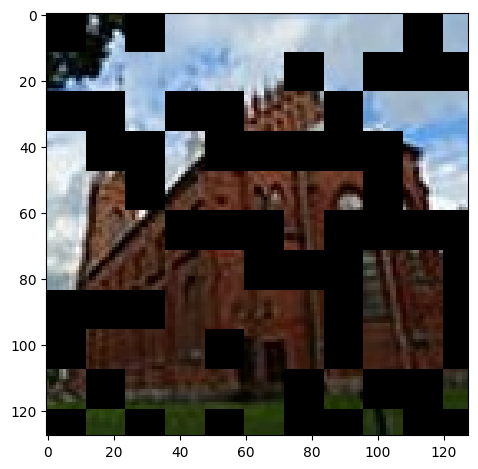

In [200]:
skimage.io.imshow(perturb.detach().numpy() / 255.)

In [202]:
predictions = list()
model.eval()

for i in range(0, perturbations.shape[0]):
    print(i)

    ski_perturbed_img = perturb_image(
        example_image[0].permute(1, 2, 0),
        perturbations[i],
        superpixels)
    print(ski_perturbed_img.shape)
    perturbed_img = torch.permute(ski_perturbed_img, [2, 0, 1])
    perturbed_img = torch.unsqueeze(perturbed_img, dim=0)

    pred1 = model_tt(batch_x.float())
    pred2 = t_lin(pred1[:, :, 0, 0].detach())
    predictions.append(pred2.detach().cpu())

0
torch.Size([128, 128, 3])
1
torch.Size([128, 128, 3])
2
torch.Size([128, 128, 3])
3
torch.Size([128, 128, 3])
4
torch.Size([128, 128, 3])
5
torch.Size([128, 128, 3])
6
torch.Size([128, 128, 3])
7
torch.Size([128, 128, 3])
8
torch.Size([128, 128, 3])
9
torch.Size([128, 128, 3])
10
torch.Size([128, 128, 3])
11
torch.Size([128, 128, 3])
12
torch.Size([128, 128, 3])
13
torch.Size([128, 128, 3])
14
torch.Size([128, 128, 3])
15
torch.Size([128, 128, 3])
16
torch.Size([128, 128, 3])
17
torch.Size([128, 128, 3])
18
torch.Size([128, 128, 3])
19
torch.Size([128, 128, 3])
20
torch.Size([128, 128, 3])
21
torch.Size([128, 128, 3])
22
torch.Size([128, 128, 3])
23
torch.Size([128, 128, 3])
24
torch.Size([128, 128, 3])
25
torch.Size([128, 128, 3])
26
torch.Size([128, 128, 3])
27
torch.Size([128, 128, 3])
28
torch.Size([128, 128, 3])
29
torch.Size([128, 128, 3])
30
torch.Size([128, 128, 3])
31
torch.Size([128, 128, 3])
32
torch.Size([128, 128, 3])
33
torch.Size([128, 128, 3])
34
torch.Size([128, 128,

In [204]:
pred = torch.cat(predictions)
pred_softmax = torch.nn.functional.softmax(pred, dim=1)

In [205]:
predictions[0],pred_softmax

(tensor([[-3.6870, -4.2234, -4.6557, -5.5580, -4.1315, -4.3477, -2.9293, -3.4955,
          -2.0649, -3.1779, -3.5991]]),
 tensor([[0.0693, 0.0405, 0.0263,  ..., 0.3507, 0.1152, 0.0756],
         [0.0693, 0.0405, 0.0263,  ..., 0.3507, 0.1152, 0.0756],
         [0.0693, 0.0405, 0.0263,  ..., 0.3507, 0.1152, 0.0756],
         ...,
         [0.0693, 0.0405, 0.0263,  ..., 0.3507, 0.1152, 0.0756],
         [0.0693, 0.0405, 0.0263,  ..., 0.3507, 0.1152, 0.0756],
         [0.0693, 0.0405, 0.0263,  ..., 0.3507, 0.1152, 0.0756]]))

In [206]:
y_true, classes_to_enumerate

(tensor([[9]]),
 {'column': tensor([[0]]),
  'flying_buttress': tensor([[1]]),
  'portal': tensor([[2]]),
  'dome(inner)': tensor([[3]]),
  'altar': tensor([[4]]),
  'bell_tower': tensor([[5]]),
  'vault': tensor([[6]]),
  'gargoyle': tensor([[7]]),
  'dome(outer)': tensor([[8]]),
  'apse': tensor([[9]]),
  'stained_glass': tensor([[10]])})

In [209]:
test_class = 8
y_pred = [
    pred_softmax[element_i][test_class].detach().numpy()
    for element_i in range(pred_softmax.shape[0])
]

As we can see the prediciton does not change with the different output. We can't use a proper simple model to modelise the change.

In [210]:
y_pred

[array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.3506837, dtype=float32),
 array(0.35068

In [211]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=y_pred)


LinearRegression()

In [212]:
coeff = simpler_model.coef_
coeff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

As we can see, the linear model cannot find an useful representation. This shows the limits of LIME.

## LIME with a stained glass picture


Here we will use a stained glass picture.

In [157]:
example_image = torchvision.io.read_image('buntglassfenster_beispiel.jpg')
example_image = example_image.float() / 255
example_image = torch.unsqueeze(example_image, dim=0)
classes_to_enumerate

{'column': tensor([[0]]),
 'flying_buttress': tensor([[1]]),
 'portal': tensor([[2]]),
 'dome(inner)': tensor([[3]]),
 'altar': tensor([[4]]),
 'bell_tower': tensor([[5]]),
 'vault': tensor([[6]]),
 'gargoyle': tensor([[7]]),
 'dome(outer)': tensor([[8]]),
 'apse': tensor([[9]]),
 'stained_glass': tensor([[10]])}

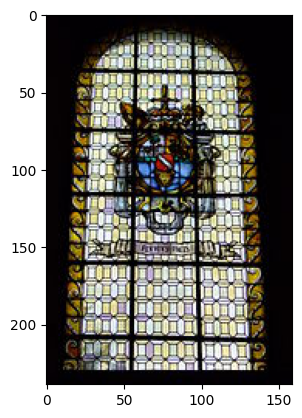

In [158]:
plt.imshow(example_image[0].permute(1, 2, 0)) 
plt.show()

In [159]:




def create_grid_segmentation(
    img,
    grid_n_x_axes = 10,
    grid_n_y_axes = 10
    ):
    size_y = img.shape[1]
    size_x = img.shape[0]

    step_y = math.floor(size_y / grid_n_y_axes)
    step_x = math.floor(size_x / grid_n_x_axes)

    class_area = 1
    result_pic = np.zeros((size_x, size_y), dtype=int)

    whiteboard = np.zeros(example_image.shape)
    for x_lower_border in range(0, size_x, step_x, ):
        for y_lower_border in range(0, size_y, step_y):
            x_higher_border = min(x_lower_border + step_x, size_x)
            y_higher_border = min(y_lower_border + step_y, size_y)

            if x_lower_border == x_higher_border or y_lower_border == y_higher_border:
                continue

            np_area = np.ones((x_higher_border - x_lower_border, y_higher_border - y_lower_border))  * class_area
            result_pic[x_lower_border:x_higher_border, y_lower_border:y_higher_border] = \
                np_area
            class_area += 1
    return result_pic



In [174]:
superpixels = create_grid_segmentation(example_image[0].permute(1, 2, 0), grid_n_x_axes=10, grid_n_y_axes=10)

In [175]:
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

121

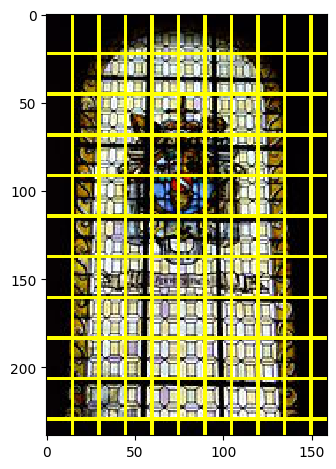

In [176]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(example_image[0].permute(1, 2, 0).detach().numpy(), superpixels))

In [177]:
num_perturb = num_superpixels #lineare regressino works like that #150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] 

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1])

In [178]:
len(perturbations)

121

In [179]:


def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image



In [180]:
perturb = perturb_image(example_image[0].permute(1, 2, 0),perturbations[0],superpixels)

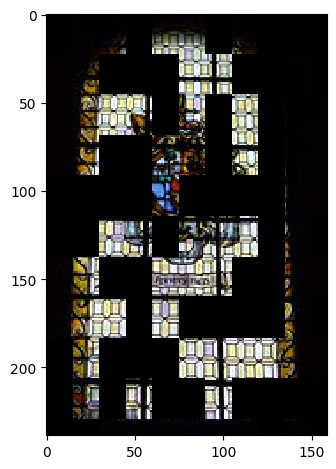

In [181]:
skimage.io.imshow(perturb.detach().numpy())

In [182]:
predictions = list()
model.eval()

for i in range(0, perturbations.shape[0]):
    print(i)

    ski_perturbed_img = perturb_image(
        example_image[0].permute(1, 2, 0),
        perturbations[i],
        superpixels)
    print(ski_perturbed_img.shape)
    perturbed_img = torch.permute(ski_perturbed_img, [2, 0, 1])
    perturbed_img = torch.unsqueeze(perturbed_img, dim=0)

    pred1 = model_tt(batch_x.float())
    pred2 = t_lin(pred1[:, :, 0, 0].detach())
    predictions.append(pred2.detach().cpu())

0
torch.Size([239, 159, 3])
1
torch.Size([239, 159, 3])
2
torch.Size([239, 159, 3])
3
torch.Size([239, 159, 3])
4
torch.Size([239, 159, 3])
5
torch.Size([239, 159, 3])
6
torch.Size([239, 159, 3])
7
torch.Size([239, 159, 3])
8
torch.Size([239, 159, 3])
9
torch.Size([239, 159, 3])
10
torch.Size([239, 159, 3])
11
torch.Size([239, 159, 3])
12
torch.Size([239, 159, 3])
13
torch.Size([239, 159, 3])
14
torch.Size([239, 159, 3])
15
torch.Size([239, 159, 3])
16
torch.Size([239, 159, 3])
17
torch.Size([239, 159, 3])
18
torch.Size([239, 159, 3])
19
torch.Size([239, 159, 3])
20
torch.Size([239, 159, 3])
21
torch.Size([239, 159, 3])
22
torch.Size([239, 159, 3])
23
torch.Size([239, 159, 3])
24
torch.Size([239, 159, 3])
25
torch.Size([239, 159, 3])
26
torch.Size([239, 159, 3])
27
torch.Size([239, 159, 3])
28
torch.Size([239, 159, 3])
29
torch.Size([239, 159, 3])
30
torch.Size([239, 159, 3])
31
torch.Size([239, 159, 3])
32
torch.Size([239, 159, 3])
33
torch.Size([239, 159, 3])
34
torch.Size([239, 159,

In [183]:
pred = torch.cat(predictions)
pred_softmax = torch.nn.functional.softmax(pred, dim=1)

In [186]:
test_class = 9
y_pred = [
    pred_softmax[element_i][test_class].detach().numpy()
    for element_i in range(pred_softmax.shape[0])
]

In [187]:
y_pred

[array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, dtype=float32),
 array(0.25745657, d

In [77]:
len(perturbations), len(y_pred), pred_softmax.shape

(16, 7, torch.Size([7, 11]))

In [188]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=y_pred)


LinearRegression()

Again the results are not very good so we clearly see the limits of LIME.